Example of integrating an orbit in a time-dependent potential of the Milky Way + LMC.
We integrate the orbit of Sgr backward in time for 3 Gyr under various assumptions:
fixed or evolving potential, test-particle orbit or massive particle with dynamical friction,
and finally compare these with the orbit from the actual N-body simulation.
Of course, one may adapt this example to explore orbits of other objects in the outer
parts of the Milky Way in the presence of the LMC. Note that the trajectory of the LMC
and the corresponding acceleration of the Milky Way-centered reference frame are provided
only for the duration of the original simulation (-3 to 0 Gyr), and for convenience,
extrapolated to -5 Gyr assuming a simple two-body interaction model. The LMC is not unbound
and would have returned back at earlier times, which is likely unphysical.
Thus the orbit integration should only be carried within this interval.


In [3]:
import agama
import numpy
import scipy.integrate, scipy.special
import matplotlib
import matplotlib.pyplot as plt


In [4]:
# present-day position and velocity of the Sgr remnant
l0, b0 = 5.61, -14.09   # Galactic coords [deg]
dist   = 27.0           # heliocentric distance [kpc]
pml,pmb= -2.31, 1.94    # proper motion components [mas/yr]
vlos   = 142            # heliocentric line-of-sight velocity [km/s]
# Convert these values into the orbit initial conditions in the Galactocentric coordinate system.
# This could be performed with astropy.coordinates, but here we employ built-in routines from Agama,
# which do not have sophisticated unit handling machinery and assume a fixed choice of units
d2r = numpy.pi/180      # degrees to radians
masyr2kmskpc = 4.74     # mas/yr to km/s/kpc
ic = agama.getGalactocentricFromGalactic(l0*d2r, b0*d2r, dist, pml*masyr2kmskpc, pmb*masyr2kmskpc, vlos)


In [8]:



# initialize the potential of the Milky Way + LMC in two variants
pot_frozen   = agama.Potential('../agama/lmc/potential_frozen.ini')   # fixed analytic potentials
pot_evolving = agama.Potential('../agama/lmc/potential_evolving.ini') # time-dependent multipole potentials

### Example 1: integrate the test-particle orbit of the Sgr backward in time in a frozen analytic potential,
# using the built-in routine from Agama (it works equally well with an evolving potential).
timeinit = -3.0  # 3 Gyr back in time - the earliest point in the Sgr simulation
timecurr =  0.0  # current time is 0, the final point
time, orbit_test = agama.orbit(ic=ic, potential=pot_frozen, timestart=timecurr,
    time=timeinit-timecurr, trajsize=100)

### Example 2: integrate the orbit backward in time, taking into account dynamical friction.
# Agama does not currently provide an option to account for dynamical friction, so we use
# a generic ODE solver from scipy (of course, this is *MUCH* slower than using the built-in routine.
# To simulate dynamical friction, we need to set up the time-dependent mass of the Sgr remnant
# and a couple of other parameters:
sigma = 120.0      # halo velocity dispersion (assume a fixed value for simplicity)
coulombLog = 2.0   # Coulomb logarithm - also assume a fiducial value
# mass of the remnant (in units of 232500 Msun, in which G=1) - assume a simple linear mass loss
mass = lambda t: numpy.interp(t, [timeinit+2.75, 0.25], [16000, 1000])

# ODE for the orbit integration
def difeq(xv, t):
    vel   = xv[3:6]
    vmag  = sum(vel**2)**0.5
    rho   = pot.density(xv[0:3], t=t)
    X     = vmag / (sigma * 2**.5)
    drag  = -4*numpy.pi * rho / vmag * \
        (scipy.special.erf(X) - 2/numpy.pi**0.5 * X * numpy.exp(-X*X)) * coulombLog * mass(t) / vmag**2
    force = pot.force(xv[0:3], t=t) + vel * drag
    return numpy.hstack((xv[3:6], force))

# grid in time from -3 Gyr up to now
time = numpy.linspace(timecurr, timeinit, 100)
# orbit in the frozen potential (fixed to the initial MW and LMC profiles before their encounter)
pot  = pot_frozen
orbit_frozen   = scipy.integrate.odeint(difeq, ic, time)
# orbit in the evolving MW and LMC potentials
pot  = pot_evolving
orbit_evolving = scipy.integrate.odeint(difeq, ic, time)



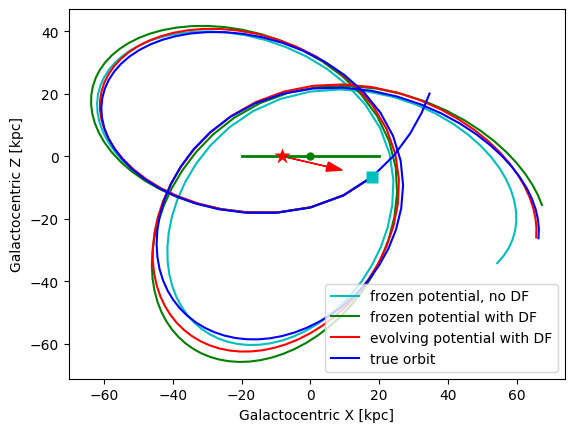

In [9]:
### show the results, along with the actual Sgr trajectory from an N-body simulation
orbit_true = numpy.loadtxt('/astro/dboyea/Sgr_snapshot/trajectory.txt')[:,1:7]  # column 0 is time, 1-7 are pos/vel
plt.plot(orbit_test    [:,0], orbit_test    [:,2], c='c', label='frozen potential, no DF')
plt.plot(orbit_frozen  [:,0], orbit_frozen  [:,2], c='g', label='frozen potential with DF')
plt.plot(orbit_evolving[:,0], orbit_evolving[:,2], c='r', label='evolving potential with DF')
plt.plot(orbit_true    [:,0], orbit_true    [:,2], c='b', label='true orbit')
plt.xlabel('Galactocentric X [kpc]')
plt.ylabel('Galactocentric Z [kpc]')
# draw a MW disc, Solar position, current Sgr position, and the line of sight
plt.plot([-20,20],[0,0], color='g', lw=2)               # galactic plane
plt.plot(0, 0, 'o', color='g', ms=6, mec='none')        # galactic center
plt.plot(-8.122, 0.02, '*', c='r', ms=12, mec='none')   # observer location
plt.plot(ic[0], ic[2], 's', c='c', ms=8, mec='none')    # Sgr remnant
plt.gca().add_artist(matplotlib.patches.FancyArrow(-8.122, 0.02, (ic[0]+8.122)/2, (ic[2]-0.02)/2,
    color='r', head_width=3, clip_on=False))  # line of sight
plt.legend(loc='lower right')
plt.show()